# Import Data

In [ ]:
import os
import pandas as pd
from keras.preprocessing import image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from glob import glob

In [ ]:
#setup environment for API token so we can use kaggle api to download dataset
os.environ["KAGGLE_USERNAME"] = 'kevincui111'
os.environ["KAGGLE_CONFIG_DIR"] = '/content/'
os.environ["KAGGLE_KEY"] = 'b8d84fede56341cc386a8916cac3982c'



In [ ]:
#Download cancer detection dataset
!kaggle competitions download -c histopathologic-cancer-detection

histopathologic-cancer-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#to permenently save checkpoints
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir data
!unzip -n histopathologic-cancer-detection.zip -d data

# Exploring Data

In [ ]:
!ls data

sample_submission.csv  test  train  train_labels.csv


In [ ]:
print("Number of training images:",len(os.listdir('data/test/')))
print("Number of test images:", len(os.listdir('data/train/')))

Number of training images: 57458
Number of test images: 220025


In [ ]:
train_labels = pd.read_csv('data/train_labels.csv')
train_labels.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [ ]:
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [ ]:
# read the image

def display_img(file):
  img = cv2.imread(file)
# format it to be in the RGB colorspace
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# resize to 300x300 and normalize pixel values to be in the range [0, 1]
  img = cv2.resize(img, (300, 300)) / 255.0
  #img = img / 255.0
  #preview the image
  plt.figure(figsize=(2, 2))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

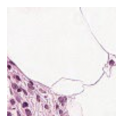

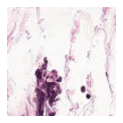

In [ ]:
file_negative = 'data/train/f38a6374c348f90b587e046aac6079959adf3835.tif'
file_positive = 'data/train/c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif'
display_img(file_negative)
display_img(file_positive)


# Data Augmentation

In [ ]:
!mkdir temp
!cp data/train/c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif temp
!cp data/train/f38a6374c348f90b587e046aac6079959adf3835.tif temp

In [ ]:

train_path = 'temp'
pattern = os.path.join(train_path,'*.tif')
glob(pattern)

['temp/f38a6374c348f90b587e046aac6079959adf3835.tif',
 'temp/c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif']

In [ ]:
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))})
df.head()

,path
0,temp/f38a6374c348f90b587e046aac6079959adf3835.tif
1,temp/c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif


In [ ]:
get_file_name_from_path = lambda x: (x.split('/')[-1])
extract_imgID_from_file_path = lambda x: (get_file_name_from_path(x).split('.')[0])
#extract_imgID_from_file_path('temp/c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif')
#-> c18f2d887b7ae4f6742ee445113fa1aef383ed77

In [ ]:
df['id'] = df.path.map(extract_imgID_from_file_path)

In [ ]:
#df

In [ ]:
df = df.merge(train_labels, on = "id")
df['label'] = df['label'].astype(str)

In [ ]:
#df

In [ ]:
TRAINING_DIR = "data/train/"
VALIDATION_SPLIT = 0.02

df = pd.DataFrame({'path': glob(os.path.join(TRAINING_DIR,'*.tif'))})
df['id'] = df.path.map(extract_imgID_from_file_path)
df = df.merge(train_labels, on = "id")
df['label'] = df['label'].astype(str)

datagen = ImageDataGenerator(rescale=1./255,
    vertical_flip=True,
    horizontal_flip=True,
    rotation_range=10,
    brightness_range=(0.8, 1.2),
    channel_shift_range=16,
    zoom_range=0.1,
    validation_split=VALIDATION_SPLIT)

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=None,
    x_col='path',
    y_col='label',
    target_size=(112, 112),
    # classes=[0, 1],
    class_mode="binary",
    batch_size=64,
    subset='training')

validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=None,
    x_col='path',
    y_col='label',
    target_size=(112, 112),
    # classes=[0, 1],
    class_mode="binary",
    batch_size=64,
    subset='validation')
images_test, labels_test = next(train_generator)
print(images_test.dtype, images_test.shape)
print(labels_test.dtype, labels_test.shape)



Found 215625 validated image filenames belonging to 2 classes.
Found 4400 validated image filenames belonging to 2 classes.
float32 (64, 112, 112, 3)
float32 (64,)


In [ ]:
# ds = tf.data.Dataset.from_generator(
#     lambda: train_generator,
#     output_types=images_test.dtype,
#     output_shapes=images_test.shape)
# ds.element_spec

# Build the Architecture

In [ ]:
def feature_extractor(inputs):
  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224,
                                                                         224, 3),
  include_top=False,
  weights='imagenet')(inputs)
  return feature_extractor

def classifier(inputs):
  x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1024, activation="relu")(x)
  x = tf.keras.layers.Dense(512, activation="relu")(x)
  x = tf.keras.layers.Dense(1, activation="sigmoid", name="classification")(x)
  return x

def cancer_detector(inputs):
  resize = tf.keras.layers.UpSampling2D(size=(2, 2))(inputs)
  resnet_feature_extractor = feature_extractor(resize)
  classification_output = classifier(resnet_feature_extractor)
  return classification_output

def build_model():
  inputs = tf.keras.layers.Input(shape=(112,112,3))
  classification_output = cancer_detector(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics = ['accuracy'])
  return model

model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              209817

In [ ]:
EPOCHS = 4
#history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
checkpoint = tf.train.Checkpoint(model)
save_path = checkpoint.save('drive/MyDrive/training_checkpoints')
history = model.fit(train_generator, epochs=EPOCHS, batch_size=64,
                    #validation_data=validation_generator,
                    use_multiprocessing=True,
                    callbacks=[callback])

Epoch 1/4
